หากต้องการใช้ไลบรารีสนับสนุน mlxtend (https://github.com/rasbt/mlxtend) 
สำหรับพล็อตเส้นแสดงเขตการจำแนก สามารถติดตั้งไลบรารีโดยรันเซลล์ด้านล่าง

In [ ]:
#!pip install mlxtend

นำเข้าไลบรารีทั้งหมดที่ใช้งาน

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.io import loadmat
import sklearn
import sklearn.datasets
from mlxtend.plotting import plot_decision_regions

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

ตัวอย่างนี้ใช้ข้อมูลในแบบฝึกหัดสัปดาห์แรกของคอร์สออนไลน์ 
"Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization" 
โดย Prof.Andrew NG สำหรับผู้สนใจสามารถลงทะเบียนเรียนได้ที่ Coursera 
ในแบบฝึกหัดเพิ่มความน่าสนใจของโจทย์เป็นตำแหน่งผู้เล่น 2 
ทีมที่มีโอกาสโหม่งลูกฟุตบอลเมื่อผู้รักษาประตูเตะลูกมาในสนาม แต่โดยหลักการแล้วคือการจำแนกทวิภาคของข้อมูล 
2 กลุ่มในระนาบสองมิติ ในการสร้างและฝึกโมเดลจะใช้โค้ดไพธอนเช่นเดียวกับในบทที่ 2 
ผู้เรียนต้องเพิ่มส่วนเรกูลาร์ไรเซชัน (3.3) ลงในโค้ด ซึ่งสามารถทำให้เข้าใจได้อย่างถ่องแท้ 
แม้ว่าจะต้องอาศัยประสบการณ์การพัฒนาโปรแกรมโดยภาษาไพธอนอยู่พอสมควร ดังนั้นสำหรับในตัวอย่างนี้เราจะใช้ไลบรารี TF 
สร้างโมเดล DNN ซึ่งมีตัวเลือกในการทำเรกูลาร์ไรเซชันให้กับแต่ละชั้นของโมเดล

ข้อมูลถูกเก็บในไฟล์ "data.mat" ที่เราจะใส่ในไดเรคทอรี "datasets/" 
เขียนฟังก์ชัน ex31_load_data() เพื่อโหลดข้อมูลฝึกและทดสอบเข้าสู่แอเรย์พร้อมกับพล็อตในระนาบ 2 
มิติดังแสดงในรูปที่ 3.3

In [4]:
def ex31_load_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X']
    train_Y = data['y']
    test_X = data['Xval']
    test_Y = data['yval']
    for i in range(len(train_Y)):
        if train_Y[i,0] == 1:
            plt.scatter(train_X[i,0],train_X[i,1],c='orange', marker='^',s=40)
        else:
            plt.scatter(train_X[i,0],train_X[i,1],c='blue', marker='s',s=40)
    return train_X, train_Y, test_X, test_Y

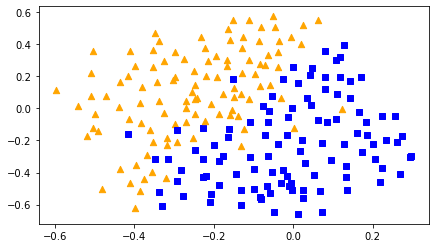

In [5]:
train_X, train_Y, test_X, test_Y = ex31_load_dataset()

รูปที่ 3.3 ข้อมูลสองมิติที่ต้องการจำแนกในตัวอย่าง 3.1

แอเรย์ข้อมูลที่คืนจากฟังก์ชัน ex31_load_dataset() เป็นชุดฝึก 211 จุดและชุดทดสอบ 200 จุด จากการประมาณโดยสายตา 
ข้อมูลในระนาบ 2 มิติในรูปที่ 3.3 สามารถถูกจำแนกได้โดยเส้นตรงในแนวทแยงมุม 
โดยพิจารณาจุดที่หลุดออกไปไกลจากกลุ่มเป็นเสมือนการรบกวน แต่โมเดลที่มีความแปรปรวนสูงจะมีแนวโน้มฟิตเกิน 
คือให้ความสำคัญกับจุดที่เป็นการรบกวนมากเกินไป 

เริ่มต้นโดยสร้างโมเดล DNN 3 ชั้นที่มีจำนวนเซลล์ 20, 30, 1 เป็นเส้นฐาน (baseline) โดยใช้ไลบรารี TF ดังนี้

In [6]:
model = Sequential([
    Flatten(input_shape=[2]),
    Dense(20, activation='relu'),
    Dense(30, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

คอมไพล์โมเดลตามรูปแบบการจำแนกทวิภาคที่ได้อธิบายในบทที่ 2 ผู้อ่านสามารถปรับอัตราการเรียนรู้ตามต้องการ

In [7]:
model.compile(optimizer=SGD(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy'])

ฝึกโมเดลจำนวน 6000 รอบ เก็บข้อมูลฝึกในดิกชันนารี history (ตัวเลือก batch_size=None กำหนดเพื่อมิให้มีการแบ่งข้อมูลเป็นกลุ่มเล็ก 
ซึ่งจะได้กล่าวถึงต่อไปในบทนี้)

In [8]:
history = model.fit(train_X, train_Y, epochs=6000, batch_size=None, validation_data=(test_X,test_Y),verbose=1)

เพื่อความสะดวกจะสร้างฟังก์ชันสำหรับพล็อตความแม่นยำและค่าสูญเสีย โดยสามารถเรียกใช้ในตัวอย่างอื่นที่จะนำเสนอต่อไป

In [18]:
def plot_acc_loss(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(acc)) # Get number of epochs

    acc_txt = str(round(acc[len(acc)-1]*100,2))
    val_acc_txt = str(round(val_acc[len(val_acc)-1]*100,2))

    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(epochs, acc,'r',epochs,val_acc,'b')
    ax1.set_title('Training and validation accuracy')
    ax1.legend(["Training acc = "+acc_txt+" %","Validation acc = "+val_acc_txt+" %"])

    loss_txt = str(round(loss[len(loss)-1],2))
    val_loss_txt = str(round(val_loss[len(val_loss)-1],2))

    ax2.plot(epochs, loss, 'r',epochs, val_loss, 'b')
    ax2.legend(["Training loss = "+loss_txt,"Validation loss = "+val_loss_txt])
    ax2.set_title('Training and validation loss');


พล็อตความแม่นยำจากชุดข้อมูลฝึกและทดสอบดังแสดงในรูปที่ 3.4 

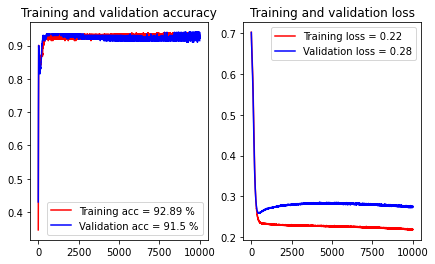

In [11]:
plot_acc_loss(history)

รูปที่ 3.4 ความแม่นยำและค่าสูญเสียจากโมเดลเส้นฐาน

สามารถสังเกตผลจากการฟิตเกินได้ในพล็อตของค่าสูญเสียทางด้านขวาของรูปที่ 3.4 
โดยขณะที่ค่าสูญเสียจากข้อมูลฝึกลดลงต่อเนื่องตามจำนวนรอบการฝึก 
ค่าสูญเสียจากข้อมูลทดสอบกลับมีแนวโน้มเพิ่มขึ้น
เมื่อพล็อตเส้นแบ่งเขตเพื่อตรวจสอบสมรรถนะการจำแนกข้อมูลจากโมเดลเส้นฐานจะได้ดังในรูปที่ 3.5


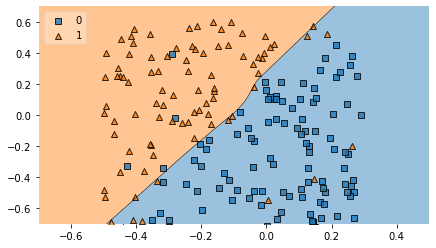

In [12]:
plot_decision_regions(test_X, np.squeeze(test_Y), clf=model, legend=2)
plt.xlim([-0.7,0.5])
plt.ylim([-0.7,0.7])
plt.show()

รูปที่ 3.5 เส้นแบ่งเขตการจำแนกข้อมูลจากโมเดลเส้นฐาน


### 3.2.2 วิธีการดรอปเอาต์

การลดการฟิตเกินอีกวิธีหนึ่งที่ใช้ได้ผลดีคือ ดรอปเอาต์ (dropout) แนวคิดคือต้องการกระจายค่านำ้หนักโดยไม่ขึ้นกับลักษณะเด่น
ของอินพุตตัวอย่างใดมากเกินไป อธิบายได้โดยดูรูปที่ 3.8 ประกอบ สมมุติว่าโครงข่ายในรูปด้านบนซ้ายคือโมเดลที่ต้องการฝึก
ในแต่ละตัวอย่างข้อมูลการฝึกจะตัดเซลล์ในแต่ละชั้นออกแบบสุ่มตามสัดส่วนที่กำหนด เช่น 30%, 50% พร้อมขจัดการเชื่อมต่อที่เป็นอินพุตและเอาต์พุตของเซลล์นั้น 
ตัวอย่างเซลล์และเส้นทางที่ถูกตัดออกแสดงโดยเส้นประ ผลคือจะได้โครงข่ายขนาดเล็กลง สังเกตว่าตำแหน่งที่ตัดเซลล์ออกจะไม่คงที่ 
เพราะเมื่อประมวลผลตัวอย่างข้อมูลใหม่ก็จะเลือกเซลล์ที่ถูกตัดออกตำแหน่งใหม่แบบสุ่ม 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1EBQHzY354lMR25n3Ptzf22IjxMzLzQg7" width=750 />
</p>
<div align="center">รูปที่ 3.8 หลักการของวิธีการดรอปเอาต์</div>

ในการอิมพลิเมนต์ดรอปเอาต์ วิธีหนึ่งที่นิยมใช้คือดรอปเอาต์ผกผัน (inverted dropout) ในกรณีที่สร้างโมเดลจากโค้ดไพธอนดังเช่นในบทที่ 
2 สมมุติว่าต้องการตัดเซลล์ในชั้น $l = 3$ สร้างเมทริกซ์ d3 โดยคำสั่ง
```python
d3 = np.random.rand(a3.shape[0],a3.shape[1]) < keep_prob
```
สังเกตว่า d3 มีขนาดเท่ากับ a3 และมีค่าขึ้นกับเงื่อนไขเปรียบเทียบค่าสุ่มที่กำเนิดจาก np.random.rand() กับตัวแปร 
keep_prob ซึ่งคือค่าสัดส่วนของเซลล์ที่ยังคงอยู่ตามที่เรากำหนด ตัวอย่างเช่นหากต้องการรักษาเซลล์ไว้ 80% 
(หรือตัดเซลล์ทิ้งไป 20%) ตั้งค่า keep_prob = 0.8 จากนั้นคำนวณเอาต์พุตจากฟังก์ชันกระตุ้นในชั้นที่ 3 ดังนี้
```python
a3 = np.multiply(a3,d3)
```
เป็นการคูณค่าเอาต์พุต a3 เดิมกับ d3 แบบสมาชิกต่อสมาชิก (คำสั่งทำงานได้ถึงแม้ว่าค่าใน d3 เป็นตรรกะ true/false)
สุดท้ายคือการปรับมาตราส่วนเพื่อชดเชยเซลล์ที่ถูกตัดทิ้งไป เพื่อทำให้ค่าคาดหมายของ a3 คงเดิม
```python
a3 /= keep_prob
```
จุดสำคัญหนึ่งของวิธีการดรอปเอาต์คือ เราจะไม่ใช้ดรอปเอาต์ในขั้นตอนการพยากรณ์ข้อมูลทดสอบ 
เพราะจะเป็นเสมือนสร้างการรบกวนในการพยากรณ์ซึ่งไม่เป็นผลดี 

**ตัวอย่าง 3.2**

ในการสร้างโมเดลโดยไลบรารี TF สามารถกำหนดชั้นดรอปเอาต์แทรกในโครงข่ายได้โดยง่าย โดยใส่อาร์กิวเมนต์ 
rate ค่าในช่วง 0-1 เป็นอัตราส่วนของเซลล์ที่ต้องการตัดทิ้ง (ตรงกันข้ามกับตัวแปร keep_prob ที่อธิบายด้านบน) 
ทดลองใช้ดรอปเอาต์เพื่อเปรียบเทียบกับโมเดลเส้นฐานและวิธีเรกูลาร์ไรเซชันในตัวอย่าง 3.1 รูปที่ 3.9 และ 3.10 
แสดงผลที่ได้จากวิธีดรอปเอาต์ซึ่งจะเห็นว่าสามารถลดผลจากการฟิตเกินได้

In [19]:
from tensorflow.keras.layers import Dropout

In [20]:
model_DO = Sequential([
    Flatten(input_shape=[2]),
    Dense(20, activation='relu'),
    Dropout(0.5),
    Dense(30, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')
])

In [21]:
model_DO.compile(optimizer=SGD(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history_DO = model_DO.fit(train_X, train_Y, epochs=6000, batch_size=None,validation_data=(test_X,test_Y),verbose=0)

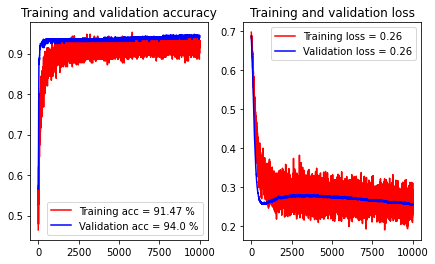

In [23]:
plot_acc_loss(history_DO)

รูปที่ 3.9 ความแม่นยำและค่าสูญเสียจากโมเดลดรอปเอาต์

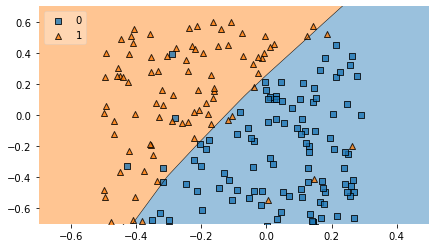

In [24]:
plot_decision_regions(test_X, np.squeeze(test_Y), clf=model_DO, legend=2)
plt.xlim([-0.7,0.5])
plt.ylim([-0.7,0.7])
plt.show()

รูปที่ 3.10 เส้นแบ่งเขตการจำแนกข้อมูลจากโมเดลดรอปเอาต์


<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja 2022</div>